<a href="https://colab.research.google.com/github/buwituze/HealthSpot_Model/blob/main/Summative_Intro_to_ml_%5BBenitha_Uwituze_Rutagengwa%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




## Project Name: HealthSpot
Case Study:

Description:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import xgboost as xgb
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')
!pip install rasterio
import rasterio
import os
import joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 18.8 MB/s eta 0:00:00


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data

### Problem Statement:

Many rural areas in Rwanda have limited access to healthcare facilities. We need to:
- Identify underserved areas (high population, low healthcare access)
- Recommend optimal locations for new healthcare facilities

### DataSet Description:

This project addresses healthcare accessibility in rural Rwanda by combining:
1. Health facility locations (572 facilities) with their coordinates and types
2. Population density data from satellite imagery (1km resolution)

### Classification Method:

1. Classify areas as "Low Access" vs "High Access" based on facility proximity and population
2. Classify potential locations as "Suitable" vs "Not Suitable" for new facilities

In [3]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/"

df_facilities = pd.read_csv(base_path + "Rwanda_Health_Facilities_Nature.csv")
print(f"Health facilities dataset shape: {df_facilities.shape}")
print(df_facilities.head())

print("Loading population density raster data...")
tif_path = base_path + "rwa_pd_2020_1km.tif"

with rasterio.open(tif_path) as src:
    population_data = src.read(1)
    transform = src.transform
    bounds = src.bounds
    crs = src.crs

    print(f"Raster shape: {population_data.shape}")
    print(f"CRS: {crs}")
    print(f"Bounds: {bounds}")

Mounted at /content/drive
Health facilities dataset shape: (572, 11)
              X              Y Country Admin1                Facility_n  \
0  3.286786e+06 -276147.439641  Rwanda  South      Kigeme Health Centre   
1  3.385482e+06 -143692.220389  Rwanda   East  Bugaragara Health Centre   
2  3.336557e+06 -224310.470995  Rwanda  South      Kigese Health Centre   
3  3.377188e+06 -192979.510510  Rwanda   East    Bugarura Health Centre   
4  3.316508e+06 -251847.843673  Rwanda  South      Kigoma Health Centre   

      Facility_t Ownership     Lat     Long LL_source  ObjectId  
0  Health Centre    Public -2.4799  29.5257       GPS         1  
1  Health Centre    Public -1.2907  30.4123       GPS         2  
2  Health Centre    Public -2.0146  29.9728       GPS         3  
3  Health Centre    Public -1.7333  30.3378       GPS         4  
4  Health Centre    Public -2.2618  29.7927       GPS         5  
Loading population density raster data...
Raster shape: (215, 245)
CRS: EPSG:4326
Bo

In [4]:
print("Converting raster to coordinate points...")
rows, cols = population_data.shape
grid_points = []

for row in range(0, rows, 5):
    for col in range(0, cols, 5):
        if population_data[row, col] > 0:
            lon, lat = rasterio.transform.xy(transform, row, col)
            pop_density = population_data[row, col]
            grid_points.append([lat, lon, pop_density])

grid_df = pd.DataFrame(grid_points, columns=['Latitude', 'Longitude', 'Population_Density'])
print(f"Created {len(grid_df)} grid points with population data")

Converting raster to coordinate points...
Created 1036 grid points with population data


In [5]:
def calculate_nearest_facility_distance(lat, lon, facilities_df):
    min_distance = float('inf')
    for _, facility in facilities_df.iterrows():
        if pd.notna(facility['Lat']) and pd.notna(facility['Long']):
            try:
                distance = geodesic((lat, lon), (facility['Lat'], facility['Long'])).kilometers
                min_distance = min(min_distance, distance)
            except:
                continue
    return min_distance if min_distance != float('inf') else 50

def count_facilities_in_radius(lat, lon, facilities_df, radius_km):
    count = 0
    for _, facility in facilities_df.iterrows():
        if pd.notna(facility['Lat']) and pd.notna(facility['Long']):
            try:
                distance = geodesic((lat, lon), (facility['Lat'], facility['Long'])).kilometers
                if distance <= radius_km:
                    count += 1
            except:
                continue
    return count

print("Calculating features...")
grid_df['Distance_to_Nearest_Facility'] = grid_df.apply(
    lambda row: calculate_nearest_facility_distance(row['Latitude'], row['Longitude'], df_facilities), axis=1
)

grid_df['Facilities_within_10km'] = grid_df.apply(
    lambda row: count_facilities_in_radius(row['Latitude'], row['Longitude'], df_facilities, 10), axis=1
)

grid_df['Facilities_within_5km'] = grid_df.apply(
    lambda row: count_facilities_in_radius(row['Latitude'], row['Longitude'], df_facilities, 5), axis=1
)

grid_df['Population_per_Facility_10km'] = grid_df['Population_Density'] / (grid_df['Facilities_within_10km'] + 1)
grid_df['Access_Score'] = (grid_df['Facilities_within_10km'] * 10 + grid_df['Facilities_within_5km'] * 20) / (grid_df['Distance_to_Nearest_Facility'] + 1)

print(f"Final dataset shape: {grid_df.shape}")

Calculating features...
Final dataset shape: (1036, 8)


In [6]:
print("Data distribution analysis:")
print(f"Distance stats: min={grid_df['Distance_to_Nearest_Facility'].min():.2f}, max={grid_df['Distance_to_Nearest_Facility'].max():.2f}")
print(f"Population stats: min={grid_df['Population_Density'].min():.2f}, max={grid_df['Population_Density'].max():.2f}")
print(f"Facilities within 10km stats: min={grid_df['Facilities_within_10km'].min()}, max={grid_df['Facilities_within_10km'].max()}")

distance_threshold = grid_df['Distance_to_Nearest_Facility'].quantile(0.6)
population_threshold = grid_df['Population_Density'].quantile(0.5)
facility_threshold = 2

grid_df['Low_Access'] = (
    (grid_df['Distance_to_Nearest_Facility'] > distance_threshold) |
    ((grid_df['Population_Density'] > population_threshold) &
     (grid_df['Facilities_within_10km'] <= facility_threshold))
).astype(int)

print(f"\nFinal class distribution:")
print(f"Low Access areas: {grid_df['Low_Access'].sum()} ({grid_df['Low_Access'].mean()*100:.1f}%)")
print(f"High Access areas: {(grid_df['Low_Access']==0).sum()} ({(1-grid_df['Low_Access'].mean())*100:.1f}%)")

if grid_df['Low_Access'].sum() < 10 or (grid_df['Low_Access']==0).sum() < 10:
    print("WARNING: Very imbalanced classes detected. Adjusting thresholds...")
    distance_threshold = grid_df['Distance_to_Nearest_Facility'].median()
    grid_df['Low_Access'] = (grid_df['Distance_to_Nearest_Facility'] > distance_threshold).astype(int)
    print(f"Adjusted class distribution:")
    print(f"Low Access areas: {grid_df['Low_Access'].sum()} ({grid_df['Low_Access'].mean()*100:.1f}%)")
    print(f"High Access areas: {(grid_df['Low_Access']==0).sum()} ({(1-grid_df['Low_Access'].mean())*100:.1f}%)")

feature_columns = [
    'Population_Density', 'Distance_to_Nearest_Facility',
    'Facilities_within_10km', 'Facilities_within_5km',
    'Population_per_Facility_10km', 'Access_Score'
]

X = grid_df[feature_columns]
y = grid_df['Low_Access']

print(f"Total samples: {len(y)}")
print(f"Class 0 (High Access): {(y==0).sum()}")
print(f"Class 1 (Low Access): {(y==1).sum()}")

Data distribution analysis:
Distance stats: min=0.02, max=23.14
Population stats: min=6.69, max=14170.92
Facilities within 10km stats: min=0, max=30

Final class distribution:
Low Access areas: 419 (40.4%)
High Access areas: 617 (59.6%)
Total samples: 1036
Class 0 (High Access): 617
Class 1 (Low Access): 419


In [7]:
# spliting data with error handling
try:
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

except ValueError as e:
    print(f"Stratified split failed: {e}")
    print("Using random split instead...")
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {X_train.shape[0]} | Validation: {X_val.shape[0]} | Test: {X_test.shape[0]}")
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Training: 621 | Validation: 207 | Test: 208
Train class distribution: [370 251]
Test class distribution: [124  84]


#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
>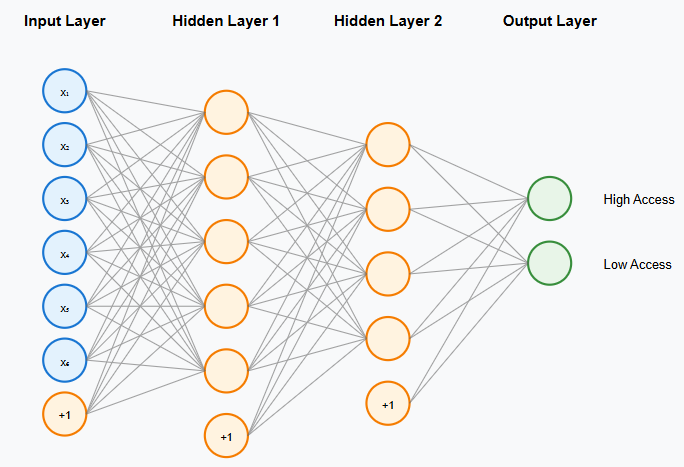




#Task: Define a function that creates models without and With specified Optimization techniques


## MODEL 1: LOGISTIC REGRESSION (Classical ML)

In [8]:
print("HealthSpot MODEL 1: LOGISTIC REGRESSION")

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

lr_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print("Training Logistic Regression model...")
lr_grid.fit(X_train_scaled, y_train)

best_lr = lr_grid.best_estimator_
print(f"Best parameters: {lr_grid.best_params_}")
print(f"Best cross-validation F1 score: {lr_grid.best_score_:.4f}")

y_pred_lr = best_lr.predict(X_test_scaled)
y_pred_proba_lr = best_lr.predict_proba(X_test_scaled)[:, 1]

os.makedirs('saved_models', exist_ok=True)
joblib.dump(best_lr, 'saved_models/1_logistic-regression.pkl')
print("Model saved as '1_logistic-regression.pkl' in saved_models folder")

HealthSpot MODEL 1: LOGISTIC REGRESSION
Training Logistic Regression model...
Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation F1 score: 0.9858
Model saved as '1_logistic-regression.pkl' in saved_models folder


## Print out the Final Model Accuracy and plot the Loss


Logistic Regression - EVALUATION RESULTS
----------------------------------------
Precision: 0.9882
Recall: 1.0000
F1-Score: 0.9941
ROC-AUC: 1.0000


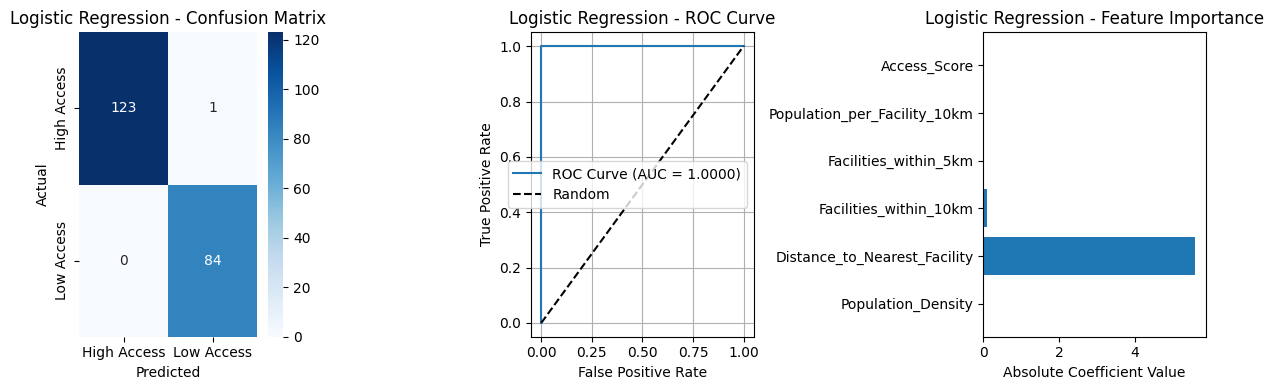

In [9]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """ Model evaluation"""
    print(f"\n{model_name} - EVALUATION RESULTS")
    print("-" * 40)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['High Access', 'Low Access'],
                yticklabels=['High Access', 'Low Access'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)

    if hasattr(best_lr, 'coef_'):
        plt.subplot(1, 3, 3)
        feature_importance = abs(best_lr.coef_[0])
        features = feature_columns
        plt.barh(features, feature_importance)
        plt.title(f'{model_name} - Feature Importance')
        plt.xlabel('Absolute Coefficient Value')

    plt.tight_layout()
    plt.show()

    return precision, recall, f1, roc_auc

lr_metrics = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression")

## MODEL 2: SIMPLE NEURAL NETWORK (No Optimization)

In [13]:
import os

print("HealthSpot MODEL 2: SIMPLE NEURAL NETWORK")

def create_simple_model(input_dim):
    """Create simple neural network without optimization techniques"""
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

simple_model = create_simple_model(X_train_scaled.shape[1])
print("Simple Neural Network Architecture:")
simple_model.summary()

print("Training unoptimized neural network...")
history_simple = simple_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

os.makedirs('saved_models', exist_ok=True)
simple_model.save('saved_models/2_neural-network.h5')
print("Model saved as '2_neural-network.h5' in saved_models folder")

HealthSpot MODEL 2: SIMPLE NEURAL NETWORK
Simple Neural Network Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

Training unoptimized neural network...
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4793 - loss: 0.7077 - val_accuracy: 0.8164 - val_loss: 0.5723
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8991 - loss: 0.5034 - val_accuracy: 0.8454 - val_loss: 0.4262
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9044 - loss: 0.3637 - val_accuracy: 0.8599 - val_loss: 0.3207
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9209 - loss: 0.2724 - val_accuracy: 0.8792 - val_loss: 0.2462
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9346 - loss: 0.2047 - val_accuracy: 0.9324 - val_loss: 0.1900
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9562 - loss: 0.1546 - val_accuracy: 0.9614 - val_loss: 0.1520
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9626 - loss: 0.1229 - val_accuracy: 0.9758 - val_loss: 0.1292
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9713 - loss: 0

Model saved as '2_neural-network.h5' in saved_models folder


## Print out the Final Model Accuracy and plot the Loss

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Simple Neural Network - EVALUATION RESULTS
----------------------------------------
Precision: 0.9882
Recall: 1.0000
F1-Score: 0.9941
ROC-AUC: 1.0000


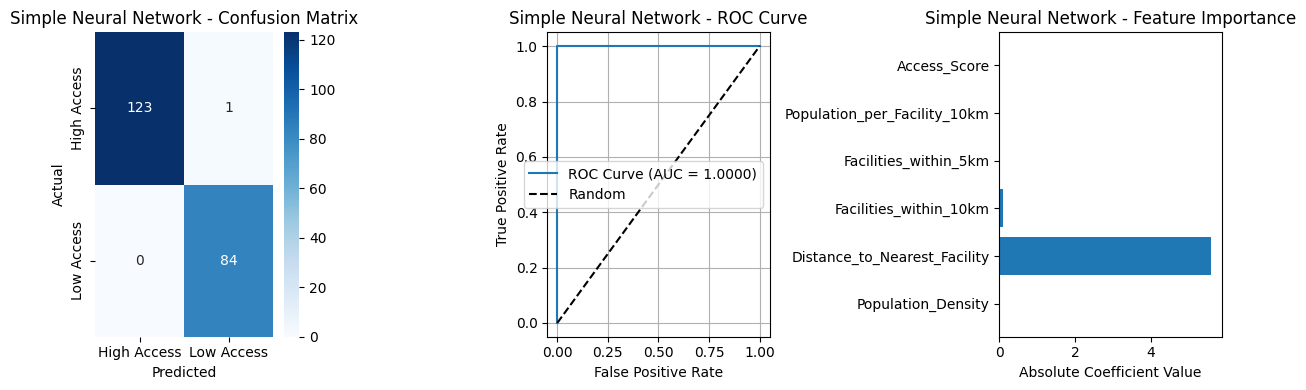

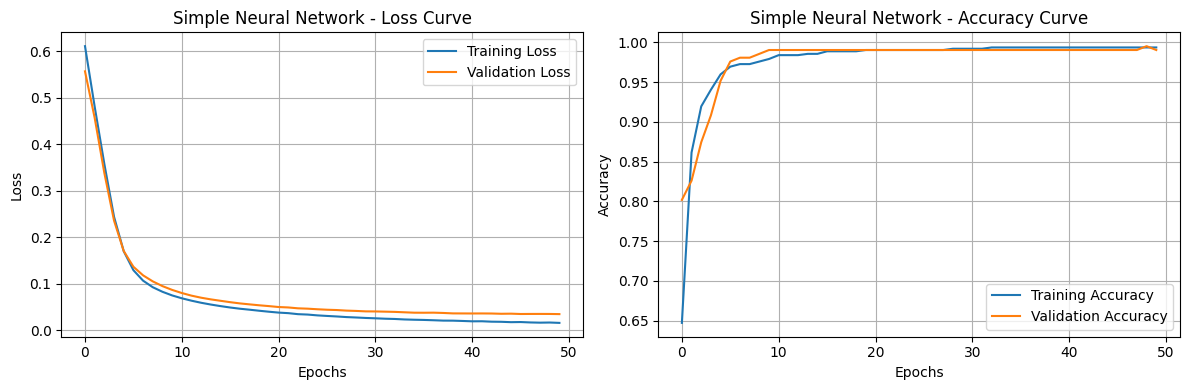

In [ ]:
y_pred_simple = (simple_model.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_pred_proba_simple = simple_model.predict(X_test_scaled).flatten()

simple_metrics = evaluate_model(y_test, y_pred_simple, y_pred_proba_simple, "Simple Neural Network")

def plot_training_history(history, model_name):
    """Plot training and validation loss/accuracy"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history_simple, "Simple Neural Network")

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

In [ ]:
print("HealthSpot MODEL 3: NEURAL NETWORKS WITH OPTIMIZATION")

import os
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

def create_optimized_model(input_dim, optimizer_config, regularizer=None, dropout_rate=0.0, num_layers=3, neurons=[64, 32, 16]):
    """
    Create neural network with specified optimization techniques

    Parameters:
    - input_dim: number of input features
    - optimizer_config: optimizer configuration (Adam, RMSprop, etc.)
    - regularizer: regularization technique (l1, l2, l1_l2)
    - dropout_rate: dropout rate for regularization
    - num_layers: number of hidden layers
    - neurons: list of neurons per layer
    """
    model = Sequential()

    if regularizer:
        model.add(Dense(neurons[0], activation='relu', input_dim=input_dim, kernel_regularizer=regularizer))
    else:
        model.add(Dense(neurons[0], activation='relu', input_dim=input_dim))

    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    for i in range(1, min(num_layers, len(neurons))):
        if regularizer:
            model.add(Dense(neurons[i], activation='relu', kernel_regularizer=regularizer))
        else:
            model.add(Dense(neurons[i], activation='relu'))

        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizer_config,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_and_evaluate_instance(model, instance_name, epochs=100, early_stopping=False, verbose=1):
    """Train model instance and return history and metrics"""

    callbacks = []
    if early_stopping:
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )
        callbacks.append(early_stop)

    print(f"\nTraining {instance_name}...")
    print(f"Model Architecture:")
    model.summary()

    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=epochs,
        batch_size=32,
        verbose=verbose,
        callbacks=callbacks
    )

    model_path = f'saved_models/{instance_name.lower().replace(" ", "_")}.h5'
    model.save(model_path)
    print(f"Model saved to: {model_path}")

    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()
    y_pred_proba = model.predict(X_test_scaled).flatten()

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    train_loss = history.history['loss'][-1]
    train_acc = history.history['accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_accuracy'][-1]

    return history, {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }

all_histories = {}
all_metrics = {}
model_configs = {}

HealthSpot MODEL 3: NEURAL NETWORKS WITH OPTIMIZATION


INSTANCE 1: Adam + L2 Regularization + Early Stopping

Training Instance_1...
Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.5675 - loss: 1.4123 - val_accuracy: 0.7923 - val_loss: 1.2947
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6760 - loss: 1.2656 - val_accuracy: 0.8744 - val_loss: 1.1489
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7747 - loss: 1.1203 - val_accuracy: 0.8696 - val_loss: 1.0057
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8329 - loss: 0.9798 - val_accuracy: 0.8792 - val_loss: 0.8774
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8496 - loss: 0.8618 - val_accuracy: 0.8744 - val_loss: 0.7685
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8946 - loss: 0.7750 - val_accuracy: 0.8792 - val_loss: 0.6757
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9074 - loss: 0.7026 - val_accuracy: 0.9034 - val_loss: 0.5960
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9371 - loss: 0.6003 - val_accuracy: 0.9275 -

Model saved to: saved_models/instance_1.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Instance 1 - EVALUATION RESULTS
----------------------------------------
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000


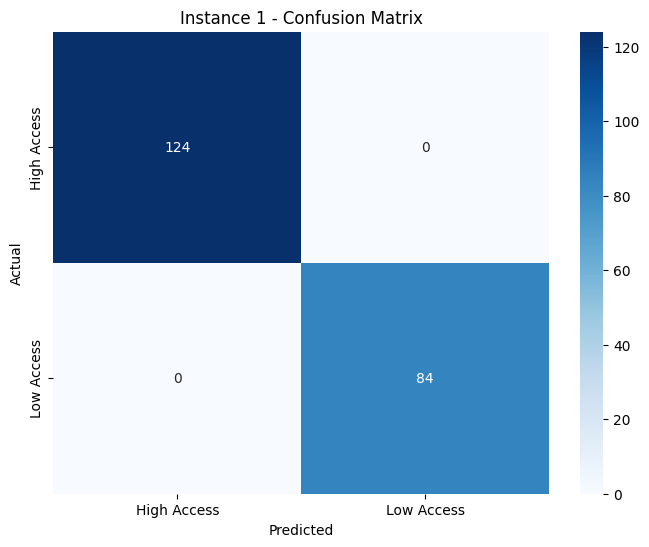

In [ ]:
# INSTANCE 1

print("INSTANCE 1: Adam + L2 Regularization + Early Stopping")


optimizer_1 = Adam(learning_rate=0.001)
regularizer_1 = l2(0.01)

model_1 = create_optimized_model(
    input_dim=X_train_scaled.shape[1],
    optimizer_config=optimizer_1,
    regularizer=regularizer_1,
    dropout_rate=0.3,
    num_layers=3,
    neurons=[64, 32, 16]
)

model_configs['Instance 1'] = {
    'Optimizer': 'Adam',
    'Learning Rate': 0.001,
    'Regularizer': 'L2 (0.01)',
    'Early Stopping': 'Yes',
    'Epochs': 100,
    'Layers': 3,
    'Dropout': 0.3
}

history_1, metrics_1 = train_and_evaluate_instance(
    model_1, "Instance_1", epochs=100, early_stopping=True, verbose=1
)

all_histories['Instance 1'] = history_1
all_metrics['Instance 1'] = metrics_1

y_pred_1 = (model_1.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_pred_proba_1 = model_1.predict(X_test_scaled).flatten()

print("\nInstance 1 - EVALUATION RESULTS")
print("-" * 40)
print(f"Precision: {metrics_1['precision']:.4f}")
print(f"Recall: {metrics_1['recall']:.4f}")
print(f"F1-Score: {metrics_1['f1']:.4f}")
print(f"ROC-AUC: {metrics_1['roc_auc']:.4f}")

cm_1 = confusion_matrix(y_test, y_pred_1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['High Access', 'Low Access'],
            yticklabels=['High Access', 'Low Access'])
plt.title('Instance 1 - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


------------------------------------------------------------
INSTANCE 2: RMSprop + L1 Regularization + Different Learning Rate
------------------------------------------------------------

Training Instance_2...
Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8228 - loss: 1.6904 - val_accuracy: 0.9324 - val_loss: 0.5706
Epoch 2/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9354 - loss: 0.5381 - val_accuracy: 0.9227 - val_loss: 0.4680
Epoch 3/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9475 - loss: 0.4444 - val_accuracy: 0.9565 - val_loss: 0.3949
Epoch 4/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9505 - loss: 0.4065 - val_accuracy: 0.9565 - val_loss: 0.3640
Epoch 5/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9599 - loss: 0.3660 - val_accuracy: 0.9614 - val_loss: 0.3459
Epoch 6/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9602 - loss: 0.3751 - val_accuracy: 0.9614 - val_loss: 0.3302
Epoch 7/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9631 - loss: 0.3375 - val_accuracy: 0.9710 - val_loss: 0.3082
Epoch 8/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9782 - loss: 0.3182 - val_accuracy: 0.9614 - val_loss

Model saved to: saved_models/instance_2.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Instance 2 - EVALUATION RESULTS
----------------------------------------
Precision: 1.0000
Recall: 0.9524
F1-Score: 0.9756
ROC-AUC: 0.9999


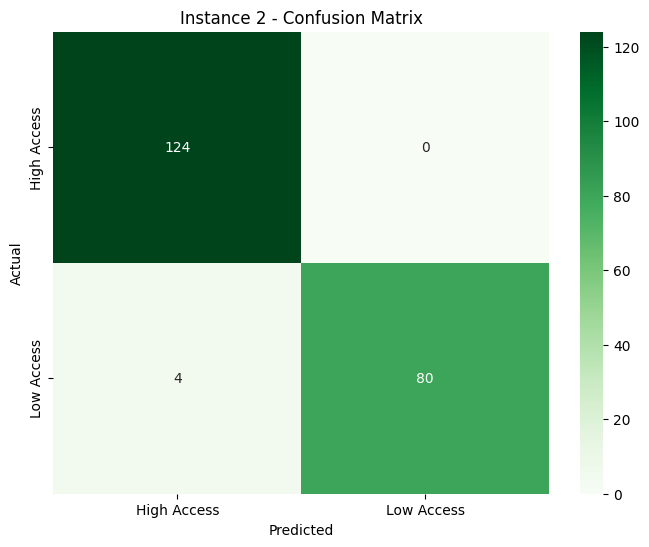

In [ ]:
# INSTANCE 2

print("\n" + "-"*60)
print("INSTANCE 2: RMSprop + L1 Regularization + Different Learning Rate")
print("-"*60)

optimizer_2 = RMSprop(learning_rate=0.01)
regularizer_2 = l1(0.005)

model_2 = create_optimized_model(
    input_dim=X_train_scaled.shape[1],
    optimizer_config=optimizer_2,
    regularizer=regularizer_2,
    dropout_rate=0.2,
    num_layers=3,
    neurons=[64, 32, 16]
)

model_configs['Instance 2'] = {
    'Optimizer': 'RMSprop',
    'Learning Rate': 0.01,
    'Regularizer': 'L1 (0.005)',
    'Early Stopping': 'No',
    'Epochs': 80,
    'Layers': 4,
    'Dropout': 0.2
}

history_2, metrics_2 = train_and_evaluate_instance(
    model_2, "Instance_2", epochs=80, early_stopping=False, verbose=1
)

all_histories['Instance 2'] = history_2
all_metrics['Instance 2'] = metrics_2

y_pred_2 = (model_2.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_pred_proba_2 = model_2.predict(X_test_scaled).flatten()

print("\nInstance 2 - EVALUATION RESULTS")
print("-" * 40)
print(f"Precision: {metrics_2['precision']:.4f}")
print(f"Recall: {metrics_2['recall']:.4f}")
print(f"F1-Score: {metrics_2['f1']:.4f}")
print(f"ROC-AUC: {metrics_2['roc_auc']:.4f}")

cm_2 = confusion_matrix(y_test, y_pred_2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Greens',
            xticklabels=['High Access', 'Low Access'],
            yticklabels=['High Access', 'Low Access'])
plt.title('Instance 2 - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

INSTANCE 3: Adam + L1_L2 Regularization + High Dropout + Early Stopping

Training Instance_3...
Model Architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.5159 - loss: 3.1794 - val_accuracy: 0.4928 - val_loss: 2.9573
Epoch 2/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5452 - loss: 2.9647 - val_accuracy: 0.7101 - val_loss: 2.8349
Epoch 3/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5660 - loss: 2.8610 - val_accuracy: 0.8357 - val_loss: 2.7202
Epoch 4/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6121 - loss: 2.7183 - val_accuracy: 0.8454 - val_loss: 2.6145
Epoch 5/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6385 - loss: 2.6209 - val_accuracy: 0.8599 - val_loss: 2.5122
Epoch 6/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6731 - loss: 2.5121 - val_accuracy: 0.8599 - val_loss: 2.4095
Epoch 7/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7057 - loss: 2.4010 - val_accuracy: 0.8502 - val_loss: 2.3064
Epoch 8/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7236 - loss: 2.3151 - val_accuracy: 0.8502 -

Model saved to: saved_models/instance_3.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Instance 3 - EVALUATION RESULTS
----------------------------------------
Precision: 0.9882
Recall: 1.0000
F1-Score: 0.9941
ROC-AUC: 0.9999


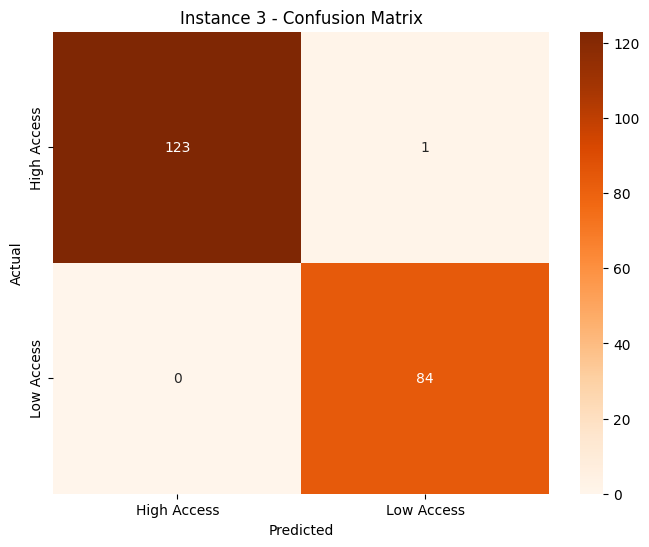

In [ ]:
# INSTANCE 3

print("INSTANCE 3: Adam + L1_L2 Regularization + High Dropout + Early Stopping")

optimizer_3 = Adam(learning_rate=0.0005)
regularizer_3 = l1_l2(l1=0.005, l2=0.005)

model_3 = create_optimized_model(
    input_dim=X_train_scaled.shape[1],
    optimizer_config=optimizer_3,
    regularizer=regularizer_3,
    dropout_rate=0.5,
    num_layers=3,
    neurons=[64, 32, 16]
)

model_configs['Instance 3'] = {
    'Optimizer': 'Adam',
    'Learning Rate': 0.0005,
    'Regularizer': 'L1_L2 (0.005, 0.005)',
    'Early Stopping': 'Yes',
    'Epochs': 120,
    'Layers': 3,
    'Dropout': 0.5
}

history_3, metrics_3 = train_and_evaluate_instance(
    model_3, "Instance_3", epochs=120, early_stopping=True, verbose=1
)

all_histories['Instance 3'] = history_3
all_metrics['Instance 3'] = metrics_3

y_pred_3 = (model_3.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_pred_proba_3 = model_3.predict(X_test_scaled).flatten()

print("\nInstance 3 - EVALUATION RESULTS")
print("-" * 40)
print(f"Precision: {metrics_3['precision']:.4f}")
print(f"Recall: {metrics_3['recall']:.4f}")
print(f"F1-Score: {metrics_3['f1']:.4f}")
print(f"ROC-AUC: {metrics_3['roc_auc']:.4f}")

cm_3 = confusion_matrix(y_test, y_pred_3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['High Access', 'Low Access'],
            yticklabels=['High Access', 'Low Access'])
plt.title('Instance 3 - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

INSTANCE 4: RMSprop + L2 Regularization + Minimal Dropout

Training Instance_4...
Model Architecture:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.8090 - loss: 0.5039 - val_accuracy: 0.8986 - val_loss: 0.2688
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9416 - loss: 0.2312 - val_accuracy: 0.9710 - val_loss: 0.1652
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9646 - loss: 0.1507 - val_accuracy: 0.9758 - val_loss: 0.1440
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9778 - loss: 0.1280 - val_accuracy: 0.9758 - val_loss: 0.1330
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9652 - loss: 0.1532 - val_accuracy: 0.9758 - val_loss: 0.1244
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9686 - loss: 0.1265 - val_accuracy: 0.9758 - val_loss: 0.1165
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9681 - loss: 0.1265 - val_accuracy: 0.9758 - val_loss: 0.1206
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9776 - loss: 0.1162 - val_accuracy: 0.9758 - val_lo

Model saved to: saved_models/instance_4.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Instance 4 - EVALUATION RESULTS
----------------------------------------
Precision: 1.0000
Recall: 0.9643
F1-Score: 0.9818
ROC-AUC: 0.9998


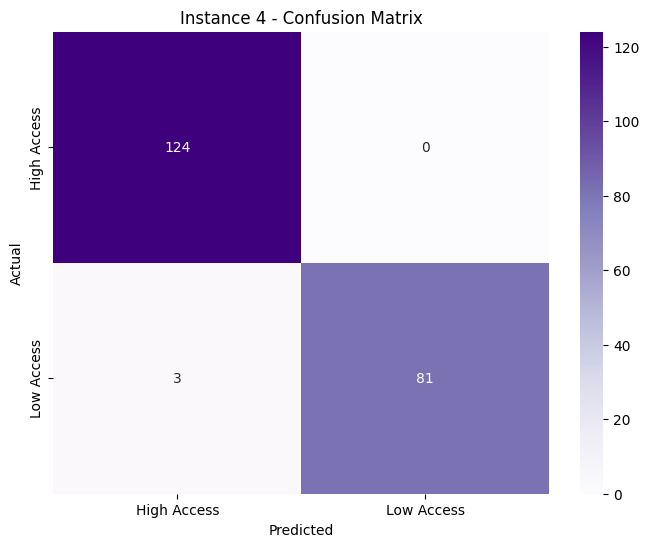

In [ ]:
# INSTANCE 4

print("INSTANCE 4: RMSprop + L2 Regularization + Minimal Dropout")

optimizer_4 = RMSprop(learning_rate=0.005)
regularizer_4 = l2(0.001)

model_4 = create_optimized_model(
    input_dim=X_train_scaled.shape[1],
    optimizer_config=optimizer_4,
    regularizer=regularizer_4,
    dropout_rate=0.1,
    num_layers=3,
    neurons=[64, 32, 16]
)

model_configs['Instance 4'] = {
    'Optimizer': 'RMSprop',
    'Learning Rate': 0.005,
    'Regularizer': 'L2 (0.001)',
    'Early Stopping': 'No',
    'Epochs': 60,
    'Layers': 2,
    'Dropout': 0.1
}

history_4, metrics_4 = train_and_evaluate_instance(
    model_4, "Instance_4", epochs=60, early_stopping=False, verbose=1
)

all_histories['Instance 4'] = history_4
all_metrics['Instance 4'] = metrics_4

y_pred_4 = (model_4.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_pred_proba_4 = model_4.predict(X_test_scaled).flatten()

print("\nInstance 4 - EVALUATION RESULTS")
print("-" * 40)
print(f"Precision: {metrics_4['precision']:.4f}")
print(f"Recall: {metrics_4['recall']:.4f}")
print(f"F1-Score: {metrics_4['f1']:.4f}")
print(f"ROC-AUC: {metrics_4['roc_auc']:.4f}")

cm_4 = confusion_matrix(y_test, y_pred_4)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_4, annot=True, fmt='d', cmap='Purples',
            xticklabels=['High Access', 'Low Access'],
            yticklabels=['High Access', 'Low Access'])
plt.title('Instance 4 - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

SIDE-BY-SIDE COMPARISON OF ALL INSTANCES


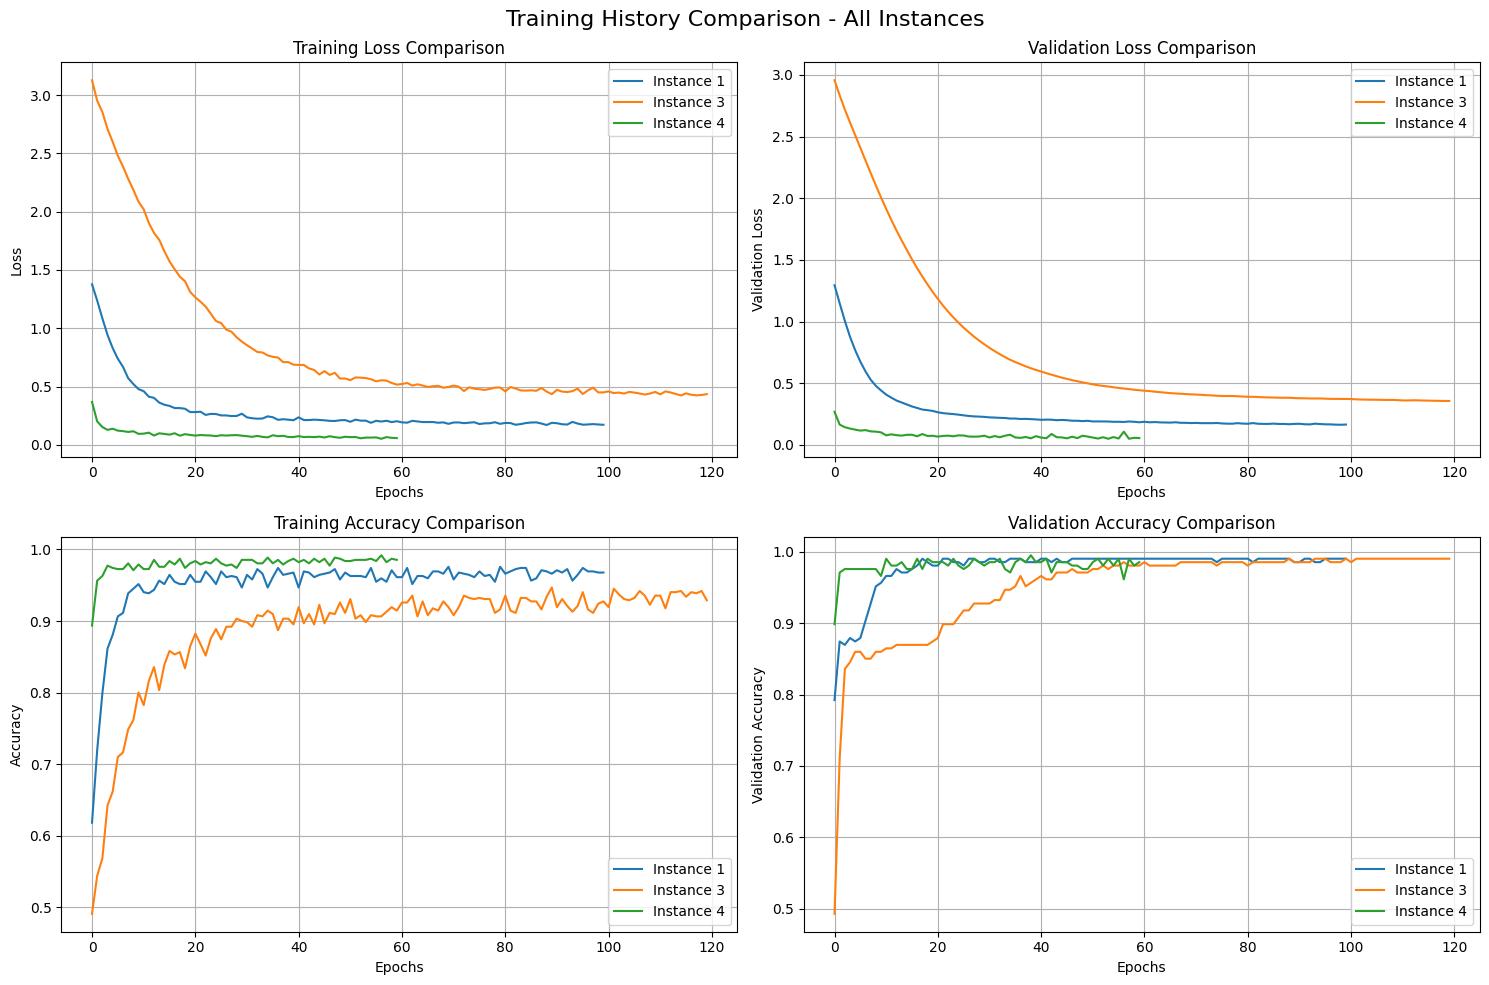


Instances Results Table
Training Instance Optimizer  Learning Rate          Regularizer Early Stopping  Epochs  Layers  Dropout Precision Recall F1-Score ROC-AUC Train Accuracy Val Accuracy
       Instance 1      Adam         0.0010            L2 (0.01)            Yes     100       3      0.3    1.0000 1.0000   1.0000  1.0000         0.9678       0.9903
       Instance 3      Adam         0.0005 L1_L2 (0.005, 0.005)            Yes     120       3      0.5    0.9882 1.0000   0.9941  0.9999         0.9291       0.9903
       Instance 4   RMSprop         0.0050           L2 (0.001)             No      60       2      0.1    1.0000 0.9643   0.9818  0.9998         0.9855       0.9855

Best Performing Instances:
Highest F1-Score: Instance 1 (F1: 1.0000)
Highest ROC-AUC: Instance 1 (ROC-AUC: 1.0000)


<Figure size 1200x800 with 0 Axes>

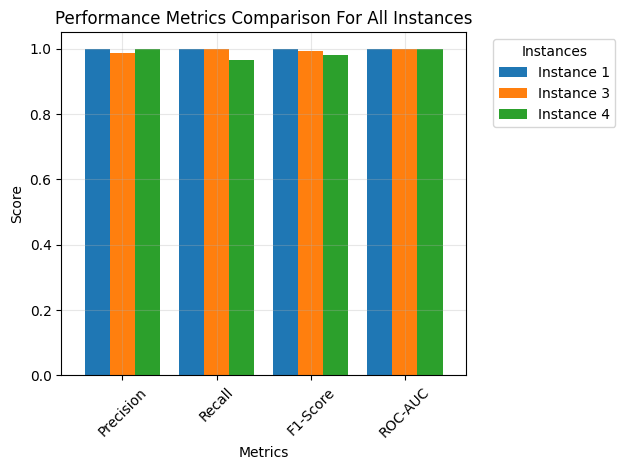

Saved models in the 'saved_models/' directory.


In [ ]:
# COMPARING ALL INSTANCES

print("SIDE-BY-SIDE COMPARISON OF ALL INSTANCES")

def plot_all_training_histories(histories):
    """Plot training histories for all instances side by side"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History Comparison - All Instances', fontsize=16)

    axes[0, 0].set_title('Training Loss Comparison')
    for name, history in histories.items():
        axes[0, 0].plot(history.history['loss'], label=f'{name}')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].set_title('Validation Loss Comparison')
    for name, history in histories.items():
        axes[0, 1].plot(history.history['val_loss'], label=f'{name}')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Validation Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    axes[1, 0].set_title('Training Accuracy Comparison')
    for name, history in histories.items():
        axes[1, 0].plot(history.history['accuracy'], label=f'{name}')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    axes[1, 1].set_title('Validation Accuracy Comparison')
    for name, history in histories.items():
        axes[1, 1].plot(history.history['val_accuracy'], label=f'{name}')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Validation Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_all_training_histories(all_histories)

print("\n" + "="*80)
print("Instances Results Table")
print("="*80)

results_data = []
for instance, config in model_configs.items():
    metrics = all_metrics[instance]
    results_data.append({
        'Training Instance': instance,
        'Optimizer': config['Optimizer'],
        'Learning Rate': config['Learning Rate'],
        'Regularizer': config['Regularizer'],
        'Early Stopping': config['Early Stopping'],
        'Epochs': config['Epochs'],
        'Layers': config['Layers'],
        'Dropout': config['Dropout'],
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1-Score': f"{metrics['f1']:.4f}",
        'ROC-AUC': f"{metrics['roc_auc']:.4f}",
        'Train Accuracy': f"{metrics['train_acc']:.4f}",
        'Val Accuracy': f"{metrics['val_acc']:.4f}"
    })

results_df = pd.DataFrame(results_data)
print(results_df.to_string(index=False))

best_f1_instance = max(all_metrics.keys(), key=lambda k: all_metrics[k]['f1'])
best_roc_instance = max(all_metrics.keys(), key=lambda k: all_metrics[k]['roc_auc'])

print(f"\nBest Performing Instances:")
print(f"Highest F1-Score: {best_f1_instance} (F1: {all_metrics[best_f1_instance]['f1']:.4f})")
print(f"Highest ROC-AUC: {best_roc_instance} (ROC-AUC: {all_metrics[best_roc_instance]['roc_auc']:.4f})")

metrics_comparison = pd.DataFrame({
    instance: [metrics['precision'], metrics['recall'], metrics['f1'], metrics['roc_auc']]
    for instance, metrics in all_metrics.items()
}, index=['Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

plt.figure(figsize=(12, 8))
metrics_comparison.plot(kind='bar', width=0.8)
plt.title('Performance Metrics Comparison For All Instances')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.legend(title='Instances', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Saved models in the 'saved_models/' directory.")

## MODEL 4: XGBoost with Hyperparameter Tuning and Rwanda Map Visualizations

HealthSpot MODEL 4: XGBoost WITH HYPERPARAMETER TUNING
Implementing XGBoost model with hyperparameter tuning...
Performing hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 128 candidates, totalling 640 fits

Best XGBoost parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best cross-validation F1 score: 0.9920
XGBoost model saved to: saved_models/xgboost_model.pkl

XGBoost - EVALUATION RESULTS
----------------------------------------
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000


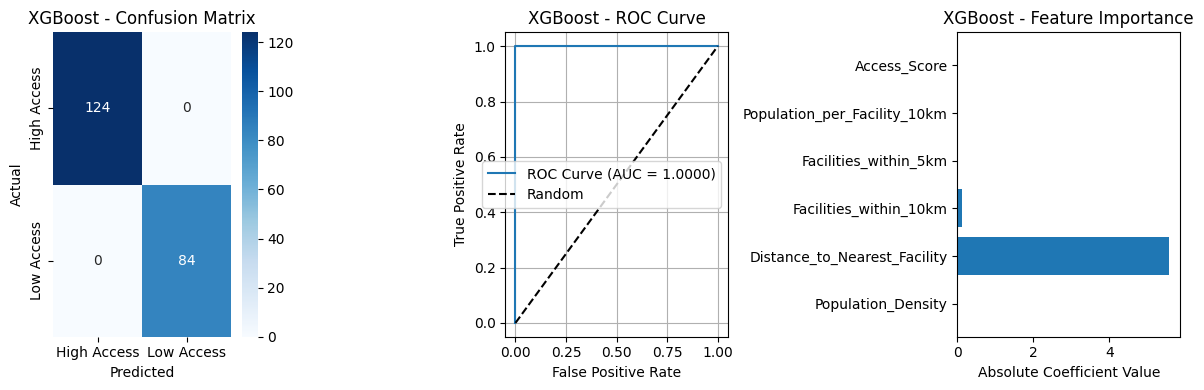

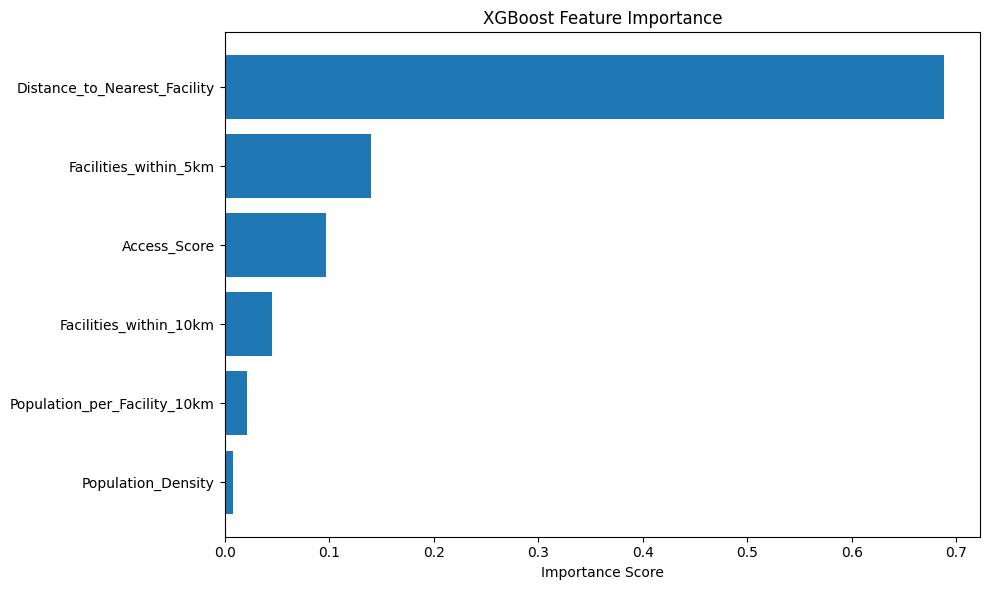


Three Most Important Features:
1. Access_Score: 0.0972
1. Facilities_within_5km: 0.1396
1. Distance_to_Nearest_Facility: 0.6883


In [ ]:
print("HealthSpot MODEL 4: XGBoost WITH HYPERPARAMETER TUNING")

import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Implementing XGBoost model with hyperparameter tuning...")

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1
)

print("Performing hyperparameter tuning with GridSearchCV...")

reduced_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

xgb_grid = GridSearchCV(
    xgb_model,
    reduced_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train_scaled, y_train)

best_xgb = xgb_grid.best_estimator_
print(f"\nBest XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best cross-validation F1 score: {xgb_grid.best_score_:.4f}")

xgb_model_path = 'saved_models/xgboost_model.pkl'
import joblib
joblib.dump(best_xgb, xgb_model_path)
print(f"XGBoost model saved to: {xgb_model_path}")

y_pred_xgb = best_xgb.predict(X_test_scaled)
y_pred_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

xgb_metrics = evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost")

feature_importance = best_xgb.feature_importances_
feature_names = feature_columns

plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print(f"\nThree Most Important Features:")
top_features = importance_df.tail(3)
for idx, row in top_features.iterrows():
    print(f"1. {row['feature']}: {row['importance']:.4f}")

# Visualization on the Rwandan Map

In [ ]:
import pandas as pd
import numpy as np
import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*50)
print("Visualizing on the Rwandan Map")
print("="*50)

# Rwanda geographical bounds
RWANDA_BOUNDS = {
    'lat_min': -2.9,
    'lat_max': -1.0,
    'lon_min': 28.8,
    'lon_max': 30.9
}

def filter_to_rwanda_bounds(df, lat_col='Latitude', lon_col='Longitude'):
    """Filter dataframe to Rwanda geographical bounds"""
    return df[
        (df[lat_col] >= RWANDA_BOUNDS['lat_min']) &
        (df[lat_col] <= RWANDA_BOUNDS['lat_max']) &
        (df[lon_col] >= RWANDA_BOUNDS['lon_min']) &
        (df[lon_col] <= RWANDA_BOUNDS['lon_max'])
    ]

def prepare_facilities_data(df_facilities):
    """Prepare and clean facilities data"""
    print("Processing facilities data...")
    print(f"df_facilities columns: {df_facilities.columns.tolist()}")

    lat_col, lon_col = None, None

    col_mapping = {
        'lat': ['lat', 'latitude', 'Lat', 'Latitude'],
        'lon': ['lon', 'lng', 'long', 'longitude', 'Long', 'Longitude']
    }


    for coord_type, variations in col_mapping.items():
        for var in variations:
            if var in df_facilities.columns:
                if coord_type == 'lat':
                    lat_col = var
                else:
                    lon_col = var
                break
        if lat_col and lon_col:
            break


    if not lat_col or not lon_col:
        raise ValueError(f"Cannot find latitude/longitude columns. Available: {df_facilities.columns.tolist()}")

    # Clean and prepare data
    rwanda_facilities = df_facilities.dropna(subset=[lat_col, lon_col]).copy()

    if lat_col != 'Latitude':
        rwanda_facilities = rwanda_facilities.rename(columns={lat_col: 'Latitude'})
    if lon_col != 'Longitude':
        rwanda_facilities = rwanda_facilities.rename(columns={lon_col: 'Longitude'})

    rwanda_facilities = filter_to_rwanda_bounds(rwanda_facilities)

    if len(rwanda_facilities) == 0:
        print("⚠️  Warning: No facilities found in Rwanda bounds, using all data")
        rwanda_facilities = df_facilities.dropna(subset=[lat_col, lon_col]).copy()
        rwanda_facilities = rwanda_facilities.rename(columns={lat_col: 'Latitude', lon_col: 'Longitude'})

    return rwanda_facilities

def create_sample_grid_data(rwanda_facilities, n_points=2000):
    """Create sample grid data for visualization"""
    print("Creating sample grid data...")

    lat_range = np.linspace(RWANDA_BOUNDS['lat_min'], RWANDA_BOUNDS['lat_max'], int(np.sqrt(n_points)))
    lon_range = np.linspace(RWANDA_BOUNDS['lon_min'], RWANDA_BOUNDS['lon_max'], int(np.sqrt(n_points)))

    lat_grid, lon_grid = np.meshgrid(lat_range, lon_range)

    grid_data = pd.DataFrame({
        'Latitude': lat_grid.flatten(),
        'Longitude': lon_grid.flatten()
    })

    np.random.seed(42)
    grid_data['Population_Density'] = np.random.exponential(50, len(grid_data))

    distances = []
    facilities_within_10km = []


    for _, point in grid_data.iterrows():
        point_distances = np.sqrt(
            (rwanda_facilities['Latitude'] - point['Latitude'])**2 +
            (rwanda_facilities['Longitude'] - point['Longitude'])**2
        ) * 111

        min_distance = point_distances.min()
        facilities_count = sum(point_distances < 10)

        distances.append(min_distance)
        facilities_within_10km.append(facilities_count)


    grid_data['Distance_to_Nearest_Facility'] = distances
    grid_data['Facilities_within_10km'] = facilities_within_10km

    grid_data['Low_Access_Probability'] = np.clip(
        (grid_data['Distance_to_Nearest_Facility'] / 30) +
        np.random.normal(0, 0.1, len(grid_data)), 0, 1
    )

    print(f"Created grid with {len(grid_data)} points")
    return grid_data


# 1. BASE HEALTH FACILITIES MAP
def create_rwanda_base_map(rwanda_facilities):
    """Create base map of Rwanda with facilities"""
    print("Creating base health facilities map...")

    fig = go.Figure()

    fig.add_trace(go.Scattermapbox(
        lat=rwanda_facilities['Latitude'],
        lon=rwanda_facilities['Longitude'],
        mode='markers',
        marker=dict(
            size=8,
            color='red',
            symbol='hospital'
        ),
        text=rwanda_facilities.get('Name_of_health_facility',
                                  rwanda_facilities.get('name', 'Health Facility')),
        hovertemplate='<b>%{text}</b><br>Lat: %{lat}<br>Lon: %{lon}<extra></extra>',
        name='Health Facilities'
    ))

    fig.update_layout(
        mapbox=dict(
            style='open-street-map',
            center=dict(
                lat=(RWANDA_BOUNDS['lat_min'] + RWANDA_BOUNDS['lat_max']) / 2,
                lon=(RWANDA_BOUNDS['lon_min'] + RWANDA_BOUNDS['lon_max']) / 2
            ),
            zoom=8
        ),
        title='Rwanda Health Facilities Distribution',
        height=600,
        margin=dict(t=50, b=0, l=0, r=0)
    )

    return fig

# 2. POPULATION DENSITY VS ACCESS PREDICTIONS
def create_population_access_map(rwanda_facilities, grid_data):
    """Create side-by-side population and access maps"""
    print("Creating population density vs access prediction maps...")

    sample_size = min(1000, len(grid_data))
    sample_data = grid_data.sample(n=sample_size, random_state=42)

    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Population Density', 'Healthcare Access Risk'),
        specs=[[{"type": "scattermapbox"}, {"type": "scattermapbox"}]]
    )

    fig.add_trace(
        go.Scattermapbox(
            lat=sample_data['Latitude'],
            lon=sample_data['Longitude'],
            mode='markers',
            marker=dict(
                size=6,
                color=sample_data['Population_Density'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title="Population Density", x=0.45)
            ),
            text=sample_data['Population_Density'].round(2),
            hovertemplate='<b>Population Density</b><br>%{text}<br>Lat: %{lat}<br>Lon: %{lon}<extra></extra>',
            name='Population'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scattermapbox(
            lat=sample_data['Latitude'],
            lon=sample_data['Longitude'],
            mode='markers',
            marker=dict(
                size=6,
                color=sample_data['Low_Access_Probability'],
                colorscale='RdYlBu_r',
                showscale=True,
                colorbar=dict(title="Low Access Risk", x=1.02)
            ),
            text=sample_data['Low_Access_Probability'].round(3),
            hovertemplate='<b>Low Access Risk</b><br>%{text}<br>Lat: %{lat}<br>Lon: %{lon}<extra></extra>',
            name='Access Risk'
        ),
        row=1, col=2
    )

    for col in [1, 2]:
        fig.add_trace(
            go.Scattermapbox(
                lat=rwanda_facilities['Latitude'],
                lon=rwanda_facilities['Longitude'],
                mode='markers',
                marker=dict(
                    size=4,
                    color='white',
                    symbol='hospital'
                ),
                hovertemplate='<b>Health Facility</b><br>Lat: %{lat}<br>Lon: %{lon}<extra></extra>',
                name='Health Facilities',
                showlegend=(col == 1)
            ),
            row=1, col=col
        )

    center_lat = (RWANDA_BOUNDS['lat_min'] + RWANDA_BOUNDS['lat_max']) / 2
    center_lon = (RWANDA_BOUNDS['lon_min'] + RWANDA_BOUNDS['lon_max']) / 2

    fig.update_layout(
        mapbox=dict(
            style='open-street-map',
            center=dict(lat=center_lat, lon=center_lon),
            zoom=7
        ),
        mapbox2=dict(
            style='open-street-map',
            center=dict(lat=center_lat, lon=center_lon),
            zoom=7
        ),
        title='Rwanda: Population Density vs Healthcare Access Risk',
        height=600,
        margin=dict(t=50, b=0, l=0, r=0)
    )

    return fig

# 3. HEALTHCARE ACCESS ZONES
def create_access_zones_map(rwanda_facilities, grid_data):
    """Create color-coded access zones map"""
    print("Creating healthcare access zones map...")

    sample_size = min(1500, len(grid_data))
    sample_data = grid_data.sample(n=sample_size, random_state=42)

    fig = go.Figure()

    zones = [
        (0, 5, 'Excellent Access (<5km)', 'green'),
        (5, 10, 'Good Access (5-10km)', 'yellow'),
        (10, 20, 'Poor Access (10-20km)', 'orange'),
        (20, float('inf'), 'Very Poor Access (>20km)', 'red')
    ]

    for min_dist, max_dist, label, color in zones:
        if max_dist == float('inf'):
            zone_data = sample_data[sample_data['Distance_to_Nearest_Facility'] >= min_dist]
        else:
            zone_data = sample_data[
                (sample_data['Distance_to_Nearest_Facility'] >= min_dist) &
                (sample_data['Distance_to_Nearest_Facility'] < max_dist)
            ]

        if len(zone_data) > 0:
            fig.add_trace(go.Scattermapbox(
                lat=zone_data['Latitude'],
                lon=zone_data['Longitude'],
                mode='markers',
                marker=dict(
                    size=5,
                    color=color,
                    opacity=0.6
                ),
                text=zone_data['Distance_to_Nearest_Facility'].round(2),
                hovertemplate=f'<b>{label}</b><br>Distance: %{{text}} km<br>Lat: %{{lat}}<br>Lon: %{{lon}}<extra></extra>',
                name=label
            ))

    fig.add_trace(go.Scattermapbox(
        lat=rwanda_facilities['Latitude'],
        lon=rwanda_facilities['Longitude'],
        mode='markers',
        marker=dict(
            size=8,
            color='black',
            symbol='hospital'
        ),
        hovertemplate='<b>Health Facility</b><br>Lat: %{lat}<br>Lon: %{lon}<extra></extra>',
        name='Health Facilities'
    ))

    fig.update_layout(
        mapbox=dict(
            style='open-street-map',
            center=dict(
                lat=(RWANDA_BOUNDS['lat_min'] + RWANDA_BOUNDS['lat_max']) / 2,
                lon=(RWANDA_BOUNDS['lon_min'] + RWANDA_BOUNDS['lon_max']) / 2
            ),
            zoom=7
        ),
        title='Rwanda Healthcare Access Zones by Distance',
        height=600,
        margin=dict(t=50, b=0, l=0, r=0)
    )

    return fig

# 4. RISK HEATMAP
def create_risk_heatmap(rwanda_facilities, grid_data):
    """Create risk density heatmap"""
    print("Creating healthcare access risk heatmap...")

    sample_size = min(1000, len(grid_data))
    sample_data = grid_data.sample(n=sample_size, random_state=42)

    fig = px.density_mapbox(
        sample_data,
        lat='Latitude',
        lon='Longitude',
        z='Low_Access_Probability',
        radius=10,
        center=dict(
            lat=(RWANDA_BOUNDS['lat_min'] + RWANDA_BOUNDS['lat_max']) / 2,
            lon=(RWANDA_BOUNDS['lon_min'] + RWANDA_BOUNDS['lon_max']) / 2
        ),
        zoom=7,
        mapbox_style='open-street-map',
        title='Rwanda: Healthcare Access Risk Heatmap',
        color_continuous_scale='RdYlBu_r',
        labels={'Low_Access_Probability': 'Low Access Risk'}
    )

    fig.add_trace(go.Scattermapbox(
        lat=rwanda_facilities['Latitude'],
        lon=rwanda_facilities['Longitude'],
        mode='markers',
        marker=dict(
            size=6,
            color='black',
            symbol='hospital'
        ),
        hovertemplate='<b>Health Facility</b><br>Lat: %{lat}<br>Lon: %{lon}<extra></extra>',
        name='Health Facilities'
    ))

    fig.update_layout(height=600)
    return fig

# 5. REGIONAL ANALYSIS
def create_regional_analysis(grid_data):
    """Create regional analysis visualization"""
    print("Creating regional analysis...")

    grid_analysis = grid_data.copy()

    lat_bins = pd.cut(grid_analysis['Latitude'], bins=4,
                     labels=['South', 'South-Central', 'North-Central', 'North'])
    lon_bins = pd.cut(grid_analysis['Longitude'], bins=4,
                     labels=['West', 'West-Central', 'East-Central', 'East'])

    grid_analysis['Lat_Region'] = lat_bins
    grid_analysis['Lon_Region'] = lon_bins

    regional_summary = grid_analysis.groupby(['Lat_Region', 'Lon_Region']).agg({
        'Low_Access_Probability': ['count', 'mean'],
        'Population_Density': 'mean',
        'Distance_to_Nearest_Facility': 'mean'
    }).round(3)

    print("\nRegional Summary:")
    print(regional_summary)

    return regional_summary

def run_rwanda_visualizations(df_facilities):
    """Run all Rwanda map visualizations"""
    try:
        rwanda_facilities = prepare_facilities_data(df_facilities)
        grid_data = create_sample_grid_data(rwanda_facilities)

        print(f"\n📊 Data Summary:")
        print(f"Health Facilities: {len(rwanda_facilities)}")
        print(f"Grid Points: {len(grid_data)}")

        print("\n🗺️  Creating visualization...")

        base_map = create_rwanda_base_map(rwanda_facilities)
        base_map.show()

        pop_access_map = create_population_access_map(rwanda_facilities, grid_data)
        pop_access_map.show()

        zones_map = create_access_zones_map(rwanda_facilities, grid_data)
        zones_map.show()

        risk_map = create_risk_heatmap(rwanda_facilities, grid_data)
        risk_map.show()

        regional_summary = create_regional_analysis(grid_data)

        print(f"\n📈 Coverage Statistics:")
        print(f"Average distance to facility: {grid_data['Distance_to_Nearest_Facility'].mean():.2f} km")
        print(f"Areas with >10km to facility: {(grid_data['Distance_to_Nearest_Facility'] > 10).sum()} "
              f"({(grid_data['Distance_to_Nearest_Facility'] > 10).mean()*100:.1f}%)")

        return {
            'facilities': rwanda_facilities,
            'grid': grid_data,
            'regional_summary': regional_summary
        }

    except Exception as e:
        print(f"❌ Error in visualization: {e}")
        import traceback
        traceback.print_exc()
        return None

print("\n🚀 Starting Rwanda Map Visualizations...")
print("="*60)

try:
    if 'df_facilities' in globals():
        results = run_rwanda_visualizations(df_facilities)
        if results:
            print(f"📊 Processed {len(results['facilities'])} health facilities")
            print(f"🗺️  Generated {len(results['grid'])} grid points for analysis")
        else:
            print("❌ Visualization failed - check error messages above")
    else:
        print("❌ Error: df_facilities not found!")
        print("💡 Make sure your facilities dataset is loaded as 'df_facilities'")
        print("   Example: df_facilities = pd.read_csv('your_facilities_file.csv')")


except Exception as e:
    print(f"❌ Error running visualizations: {e}")


Visualizing on the Rwandan Map

🚀 Starting Rwanda Map Visualizations...
Processing facilities data...
df_facilities columns: ['X', 'Y', 'Country', 'Admin1', 'Facility_n', 'Facility_t', 'Ownership', 'Lat', 'Long', 'LL_source', 'ObjectId']
Creating sample grid data...
Created grid with 1936 points

📊 Data Summary:
Health Facilities: 572
Grid Points: 1936

🗺️  Creating visualization...
Creating base health facilities map...


Creating population density vs access prediction maps...


Creating healthcare access zones map...


Creating healthcare access risk heatmap...


Creating regional analysis...

Regional Summary:
                           Low_Access_Probability        Population_Density  \
                                            count   mean               mean   
Lat_Region    Lon_Region                                                      
South         West                            121  0.403             57.242   
              West-Central                    121  0.208             54.566   
              East-Central                    121  0.668             57.858   
              East                            121  0.902             49.900   
South-Central West                            121  0.415             42.986   
              West-Central                    121  0.105             52.231   
              East-Central                    121  0.148             51.257   
              East                            121  0.182             59.380   
North-Central West                            121  0.655             50.748   
   

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [ ]:
def make_predictions(model_path, X):
    if model_path.endswith('.pkl'):
        model = joblib.load(model_path)
        predictions = model.predict(X)
    else:
        model = load_model(model_path)
        predictions = model.predict(X)
        predictions = (predictions > 0.5).astype(int).flatten()
    return predictions

In [ ]:
model_path = 'saved_models/1_logistic-regression.pkl'
lr_predictions = make_predictions(model_path, X_test_scaled)

model_path = 'saved_models/2_neural-network.h5'
nn_predictions = make_predictions(model_path, X_test_scaled)

print("Logistic Regression Results:")
lr_cm = confusion_matrix(y_test, lr_predictions)
lr_f1 = f1_score(y_test, lr_predictions)
print(f"Confusion Matrix:\n{lr_cm}")
print(f"F1 Score: {lr_f1:.4f}")

print("\nNeural Network Results:")
nn_cm = confusion_matrix(y_test, nn_predictions)
nn_f1 = f1_score(y_test, nn_predictions)
print(f"Confusion Matrix:\n{nn_cm}")
print(f"F1 Score: {nn_f1:.4f}")

# Select best model
if lr_f1 > nn_f1:
    best_model_path = 'saved_models/1_logistic-regression.pkl'
    print(f"\nBest Model: Logistic Regression (F1: {lr_f1:.4f})")
else:
    best_model_path = 'saved_models/2_neural-network.h5'
    print(f"\nBest Model: Neural Network (F1: {nn_f1:.4f})")

# Make predictions using best model
final_predictions = make_predictions(best_model_path, X_test_scaled)
print(f"\nFinal predictions using best model: {final_predictions[:10]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Logistic Regression Results:
Confusion Matrix:
[[123   1]
 [  0  84]]
F1 Score: 0.9941

Neural Network Results:
Confusion Matrix:
[[123   1]
 [  0  84]]
F1 Score: 0.9941

Best Model: Neural Network (F1: 0.9941)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Final predictions using best model: [1 1 1 0 0 0 1 0 0 0]


Congratulations!!
